In [156]:
import lateral_signaling as lsig

import os
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import skimage
import skimage.io as io
import skimage.filters as filt
import skimage.measure as msr
import cv2

import colorcet as cc

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
%load_ext blackcellmagic

<hr>

# Image processing workflow

* Read in single channel images to common shape (crop)
* Use click recording to identify vertices on the border of the well
* Find the least-squares estimate for the center of each well and radius of all wells
* Construct masked versions of the images excluding pixels outside the well
* Apply Gaussian blur to remove noise and rescale to generate normalized images
* Measure BFP/GFP fluorescence along a linear profile, adjusting for the shift between well centers

## Image I/O and pre-processing

In [237]:
# Options for saving
save_data = False
save_figs = False
fmt       = "png"
dpi       = 300

# Directory with raw images
data_dir = "E:/transceiver_project/20191116_partial_activation/"

# Directory with ROIs
roi_dir  = "C:/Users/Pranav/git/evomorph/lateral_signaling/"

# Directory to save data
data_dir = "C:/Users/Pranav/git/evomorph/data/"

# DIrector to save plots/figures
figs_dir = "C:/Users/Pranav/git/evomorph/lateral_signaling/plots/"

In [14]:
# Get image filenames
files = glob(os.path.join(data_dir, "*.tif"))
files = [os.path.realpath(f) for f in files]
n_ims = len(files)

In [15]:
# Select blue and green fluorescence images (BFP and GFP)
files_B = [f for f in files if  "blue" in f]
files_G = [f for f in files if "green" in f]

In [16]:
# Get unique name for each image
im_names = []
for f in (*files_B, *files_G):
    end = os.path.split(f)[1]
    im_names.append(end[:end.index(".")])

In [17]:
# Define viewing window of equal shape because stitched 
#   images can be of different shapes
window = np.s_[:3400, 50:3450]

In [18]:
# Load images and convert to image collections
load_B = lambda f: io.imread(f).astype(np.uint8)[window][:, :, 2]
load_G = lambda f: io.imread(f).astype(np.uint8)[window][:, :, 1]
ims_B = io.ImageCollection(files_B, load_func=load_B)
ims_G = io.ImageCollection(files_G, load_func=load_G)

In [19]:
# Get images as Numpy array
ims = np.array([im for im in (*ims_B, *ims_G)])

# Save shape of each image
imshape = ims.shape[1:]

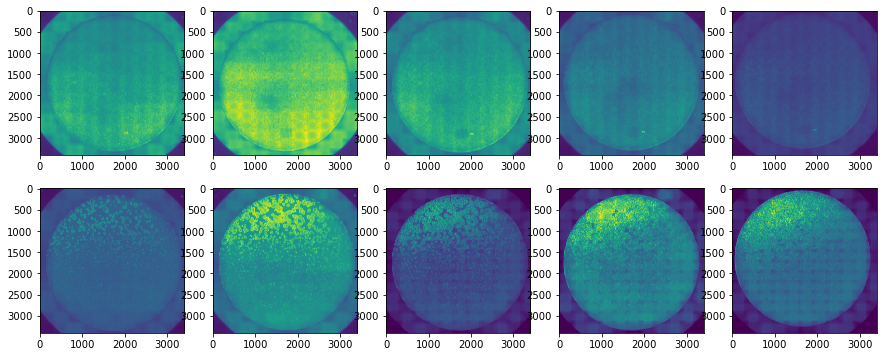

In [22]:
fig = plt.figure(figsize=(15, 6))
rows, cols = 2, 5
for i in range(rows * cols):
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(ims[i])

<hr>

In [259]:
# import bebi103

# import bokeh.io
# bokeh.io.output_notebook()

Loading BokehJS ...

In [262]:
# circle_verts_list = []

In [293]:
# im = ims_G[4]

# circle_verts = bebi103.image.draw_rois(im, flip=False,)

In [294]:
# circle_df = bebi103.image.roicds_to_df(circle_verts)
# circle_verts_list.append(circle_df.values[:, 1:])

<hr>

### Compute least-squares estimates for well center and radius

In [556]:
# # Compute center and radius of each well in pixels
# centers = np.empty((10, 2), dtype=float)
# radii   = np.empty((10,),   dtype=float)

# for i, v  in enumerate(circle_verts_list):
#     centers[i], radii[i] = lsig.verts_to_circle(v)

# # Combine into one dataset with all circle parameters
# circles = np.concatenate([centers, radii[:, np.newaxis]], axis=1)

### Save vertices and circle parameters as Pandas DataFrames $\rightarrow$ `csv`

In [555]:
# cvert_cat = np.concatenate(circle_verts_list)
# nverts = np.array([v.shape[0] for v in circle_verts_list])

# cvert_df = pd.DataFrame(dict(
#     image  = np.repeat(im_names, nverts),
#     x_vert = cvert_cat[:, 0],
#     y_vert = cvert_cat[:, 1],
# ))

# cvert_df

image  x_vert       y_vert
0    064h_blue  1734.0  3328.706276
1    064h_blue  2915.5  2810.206276
2    064h_blue  3349.0  1722.206276
3    064h_blue  2762.5   481.206276
4    064h_blue  1742.5   124.206276
..         ...     ...          ...
75  160h_green  2788.0   525.406250
76  160h_green  1700.0    57.906250
77  160h_green   569.5   482.906250
78  160h_green    59.5  1672.906250
79  160h_green   595.0  2854.406250

[80 rows x 3 columns]

In [556]:
# circles_df = pd.DataFrame(circles, index=im_names)
# circles_df.columns = ["x_center", "y_center", "radius"]

# circles_df

x_center     y_center       radius
064h_blue   1741.702661  1722.831206  1604.291982
088h_blue   1676.469223  1770.550795  1548.869349
112h_blue   1732.607950  1744.548110  1600.535739
136h_blue   1700.230257  1702.099548  1598.106241
160h_blue   1664.062468  1654.859878  1596.230702
064h_green  1737.725684  1760.328700  1600.984589
088h_green  1729.642610  1740.725046  1602.079902
112h_green  1731.393041  1745.386711  1595.840445
136h_green  1699.663521  1745.863412  1595.746360
160h_green  1656.885301  1656.176918  1599.049562

In [557]:
# if save_data:
    
#     verts_fname = "partial_activation_wave_circle_vertices.csv"
#     verts_path = os.path.join(os.path.realpath(data_dir), verts_fname)
#     cvert_df.to_csv(verts_path)
    
#     circles_fname = "partial_activation_wave_circle_ROIs.csv"
#     circles_path = os.path.join(os.path.realpath(data_dir), circles_fname)
#     circles_df.to_csv(circles_path)

<hr>

### Load circle ROIs and compute masks

In [28]:
rois_csv = os.path.join(os.path.realpath(roi_dir), "partial_activation_wave_circle_ROIs.csv")
rois_df = pd.read_csv(rois_csv, index_col=0)

In [29]:
roi_centers = rois_df[["x_center", "y_center"]].values
roi_radii   = rois_df[["radius"]].values

In [32]:
masks = [lsig.make_circular_mask(*imshape, c, r) for c, r in zip(roi_centers, roi_radii)]

# Save masked images

<hr>

In [33]:
def rescale_masked_img(im, mask, interval=(None, None), dtype=np.float64, imask_val=0):
    """
    Returns an image with intensity values inside a mask rescaled to the 
    range (0,1) and values outside the max set to a constant value.
    """
    
    # Get masked intensity values
    vals = im[mask]
    
    # Get min and max for rescaling
    if interval[0] is None:
        interval = (vals.min(), interval[1])
    if interval[1] is None:
        interval = (interval[0],vals.max())
        
    # Perform rescaling
    vals = (vals - interval[0]) / (interval[1] - interval[0])
    vals = np.maximum(np.minimum(vals, 1), 0)

    # Construct output
    imf = np.ones_like(im, dtype=dtype) * imask_val
    imf[mask] = vals
    
    return imf

In [34]:
# ims_float = np.array([rescale_masked_img(im, mask) for im, mask in zip(ims, masks)])

In [116]:
# RMSD of Gaussian blur
# sigma = 10.0
sigma = 20.

# Iterate over images
ims_filt_list = []
iterator = range(ims.shape[0])
iterator = tqdm(iterator)
for i in iterator:
    im, mask = ims[i], masks[i]
    
    im_filt = im.copy()
    
    # Convert to normalized float
    # im_filt = rescale_masked_img(im_filt, mask, dtype=np.float32)
    
    # Apply Gaussian blur
    im_filt = filt.gaussian(im_filt, sigma)
    
    # Re-normalize
    im_filt = rescale_masked_img(im_filt, mask, dtype=np.float32)
    
    ims_filt_list.append(im_filt)

ims_filt = np.array(ims_filt_list, dtype=np.float32)

100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


In [117]:
# Convert to uint8
ims_filt_uint8 = skimage.img_as_ubyte(ims_filt)

<hr>

### Save processed images

In [943]:
if save_data:

    im_fnames = [
        "partial_signaling_wave_" + f.split("_")[0] + "_BFP_processed." + fmt for f in im_names[:5]
    ] + [
        "partial_signaling_wave_" + f.split("_")[0] + "_GFP_processed." + fmt for f in im_names[5:]
    ]
    im_paths = [os.path.join(os.path.realpath(data_dir), f) for f in im_fnames]

    for i in range(n_ims):
        io.imsave(im_paths[i], ims_filt_uint8[i], )
        print("Saved:", im_paths[i])
    

<hr>

# Get source, destination, and width of line used for intensity profile

In [198]:
lp_params_csv = os.path.join(os.path.realpath(data_dir), "partial_activation_wave_line_profile_params.csv")
which_im_for_lp, lp_width = pd.read_csv(lp_params_csv, header=None).values.ravel()

In [201]:
which_im_for_lp, lp_width

(9, 800)

In [199]:
lp_csv = os.path.join(os.path.realpath(roi_dir), "partial_activation_wave_line_profile_endpoints.csv")
lp_df = pd.read_csv(lp_csv, index_col=0)
lp_vals = lp_df.values[:, 1:].astype(np.float32)

In [ ]:
lp_df

imname        x_src       y_src        x_dst        y_dst
0   064h_blue  1087.817360  457.364538  2218.317360  2939.364538
1   088h_blue  1022.583921  505.084127  2153.083921  2987.084127
2   112h_blue  1078.722649  479.081443  2209.222649  2961.081443
3   136h_blue  1046.344956  436.632881  2176.844956  2918.632881
4   160h_blue  1010.177167  389.393211  2140.677167  2871.393211
5  064h_green  1083.840383  494.862033  2214.340383  2976.862033
6  088h_green  1075.757309  475.258379  2206.257309  2957.258379
7  112h_green  1077.507740  479.920043  2208.007740  2961.920043
8  136h_green  1045.778220  480.396744  2176.278220  2962.396744
9  160h_green  1003.000000  390.710251  2133.500000  2872.710251

<hr>

In [207]:
# Get source and destination of line profile
src = lp_vals[0, :2]
dst = lp_vals[0, 2:]


lsig.get_lp_corners(src, dst, lp_width)


array([[ 723.79895,  623.1674 ],
       [1451.8358 ,  291.56165],
       [2582.3357 , 2773.5615 ],
       [1854.299  , 3105.1675 ]], dtype=float32)

# Plot layouts of images

In [217]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

Saved: C:\Users\Pranav\git\evomorph\lateral_signaling\plots\partial_signaling_wave_layout_BFP_GFP_processed.png


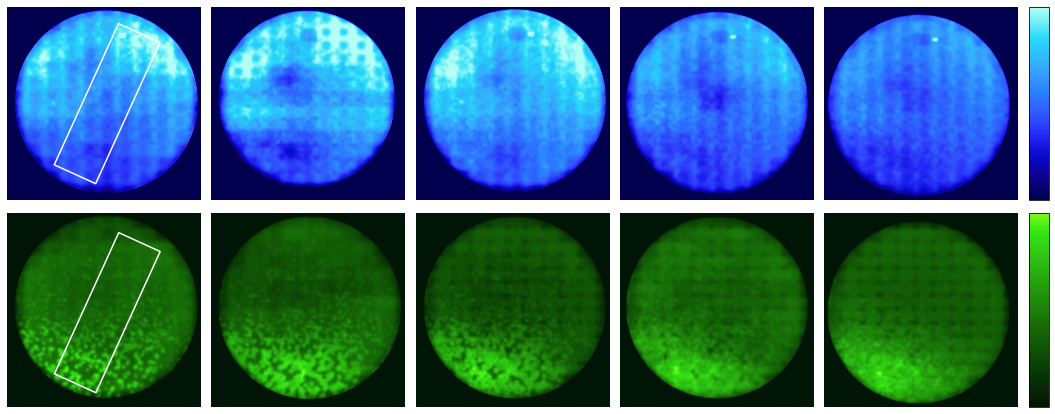

In [241]:
vmin_BFP, vmax_BFP = None, 210
vmin_GFP, vmax_GFP = None, None

rows, cols = 2, 5

cbar_aspect = 10
gs_kw = dict(width_ratios = [1 if i < cols - 1 else 1.25 for i in range(cols) ])

fig, axs = plt.subplots(rows, cols, figsize=(15, 6), gridspec_kw=gs_kw)

for i, ax in enumerate(axs.flat):
    
    cmap_ = (cc.cm["kbc"], lsig.kgy)[i // cols]
    
    ax.imshow(
        ims_filt_uint8[i, ::-1],
        cmap=cmap_,
        vmin=(vmin_BFP, vmin_GFP)[i // cols],
        vmax=(vmax_BFP, vmax_GFP)[i // cols],
    )
    ax.axis("off")
    
    if i % cols == 0:
        
        # Get source and destination of line profile
        src = np.array([imshape[0] - lp_vals[i, 0], lp_vals[i, 1]])
        dst = np.array([imshape[0] - lp_vals[i, 2], lp_vals[i, 3]])

        # Get corners of line profile
        lp_corners = lsig.get_lp_corners(src, dst, lp_width)
        # ax.plot(lp_corners[:, 0], lp_corners[:, 1], markersize=100)
        pc = PatchCollection([Polygon(lp_corners)])
        pc.set(edgecolor="w", linewidth=1.5, facecolor=(0, 0, 0, 0), )
        
        ax.add_collection(pc)
    
    if i % cols == cols - 1:
        plt.colorbar(cm.ScalarMappable(cmap=cmap_), ax=ax, shrink=0.95, ticks=[], aspect=cbar_aspect)


plt.tight_layout()

if save_figs:
    imlayout_fname = "partial_signaling_wave_layout_BFP_GFP_processed" + "." + fmt
    imlayout_path = os.path.join(os.path.realpath(figs_dir), imlayout_fname)

    plt.savefig(imlayout_path, format=fmt, dpi=dpi)
    print("Saved:", imlayout_path)

<hr>

# Intensity profiles along axis of image

In [617]:
# # Index of image used to draw line profile
# which_im_for_lp = 9

__Record clicks for intensity profile line__

In [583]:
# im, mask = ims[which_im_for_lp], masks[which_im_for_lp]
# sigma = 50.0

# im_filt = rescale_masked_img(im, mask, dtype=np.float32)
# im_filt = filt.gaussian(im_filt, sigma)
# im_filt = rescale_masked_img(im_filt, mask, dtype=np.float64)

# roi_profile_verts = bebi103.image.draw_rois(im_filt, flip=False,)

In [643]:
# roi_profile_df = bebi103.image.roicds_to_df(roi_profile_verts)

<hr>

In [825]:
# Convert profile endpoints to polar coordinates 
profile_verts_cart = roi_profile_df.values[:, 1:]
profile_verts_pol  = np.array([lsig.cart2pol(xy - centers[which_im_for_lp]) for xy in profile_verts_cart])

In [826]:
profile_verts_pol

array([[ 1.42441984e+03, -2.04772615e+00],
       [ 1.30656608e+03,  1.19739527e+00]])

In [869]:
lp_verts = np.empty((n_ims, 2, 2), dtype=np.float64)
lp_verts[:, 0, :] = lsig.pol2cart(coords_pol[0])
lp_verts[:, 1, :] = lsig.pol2cart(coords_pol[1])

for rt, c in zip(lp_verts, centers):
    rt += c

lp_verts

array([[[1087.81735981,  457.36453842],
        [2218.31735981, 2939.36453842]],

       [[1022.58392149,  505.08412722],
        [2153.08392149, 2987.08412722]],

       [[1078.72264868,  479.08144269],
        [2209.22264868, 2961.08144269]],

       [[1046.34495552,  436.63288074],
        [2176.84495552, 2918.63288074]],

       [[1010.1771667 ,  389.39321092],
        [2140.6771667 , 2871.39321092]],

       [[1083.84038279,  494.86203258],
        [2214.34038279, 2976.86203258]],

       [[1075.75730928,  475.25837904],
        [2206.25730928, 2957.25837904]],

       [[1077.50773962,  479.92004339],
        [2208.00773962, 2961.92004339]],

       [[1045.77822006,  480.39674448],
        [2176.27822006, 2962.39674448]],

       [[1003.        ,  390.71025085],
        [2133.5       , 2872.71025085]]])

In [870]:
# Get XY coordinates for source and destination of profile
x_src, y_src, x_dst, y_dst = lp_verts.reshape((n_ims, 4)).T

In [885]:
# Package into DataFrame
lp_verts_df = pd.DataFrame(dict(
    imname = im_names,
    x_src  = x_src,
    y_src  = y_src,
    x_dst  = x_dst,
    y_dst  = y_dst,
))

In [886]:
lp_verts_df

imname        x_src       y_src        x_dst        y_dst
0   064h_blue  1087.817360  457.364538  2218.317360  2939.364538
1   088h_blue  1022.583921  505.084127  2153.083921  2987.084127
2   112h_blue  1078.722649  479.081443  2209.222649  2961.081443
3   136h_blue  1046.344956  436.632881  2176.844956  2918.632881
4   160h_blue  1010.177167  389.393211  2140.677167  2871.393211
5  064h_green  1083.840383  494.862033  2214.340383  2976.862033
6  088h_green  1075.757309  475.258379  2206.257309  2957.258379
7  112h_green  1077.507740  479.920043  2208.007740  2961.920043
8  136h_green  1045.778220  480.396744  2176.278220  2962.396744
9  160h_green  1003.000000  390.710251  2133.500000  2872.710251

In [875]:
if save_data:
    profile_fname = "partial_activation_wave_line_profile_endpoints.csv"
    profile_path = os.path.join(os.path.realpath(data_dir), profile_fname)
    lp_verts_df.to_csv(profile_path)

<hr>

In [844]:
@numba.njit
def get_lp_corners(src, dst, width):
    """Given source and destination points, return the coordinates of the corners 
    of the line profile along that line segment with specified width."""
    
    assert (src.dtype is dst.dtype), "src and dst should have the same dtype"
    
    dtype = src.dtype
    src = src.ravel()
    dst = dst.ravel()
    
    # Get slope perpendicular to the line segment
    pslope = - (dst[0] - src[0]) / (dst[1] - src[1])
    
    # Get increments in x and y direction
    dx = width / (2 * np.sqrt(1 + pslope ** 2))
    dy = pslope * dx
    
    # Add/subtract increments from each point
    corners = np.empty((4, 2), dtype=dtype)
    corners[:, 0]  =  dx
    corners[:, 1]  =  dy
    corners[0]    *=  -1
    corners[3]    *=  -1
    corners[:2]   += src
    corners[2:]   += dst
    
    return corners

In [845]:
import holoviews as hv
hv.extension("matplotlib")

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

__USe those clicks as `src` and `dst` in `profile_line`__

In [846]:
# Width of line profile in pixels
lp_width = 800

In [847]:
# Format an image for HoloViews (flipped y-axis)
im_hv = ims_filt[which_im_for_lp, ::-1]

# Get source and destination of line profile
src = np.array([x_src[which_im_for_lp], y_src[which_im_for_lp]])
dst = np.array([x_dst[which_im_for_lp], y_dst[which_im_for_lp]])

# Get corners of line profile
lp_corners = get_lp_corners(src, dst, lp_width)

In [848]:
im_lp = hv.Image(
    im_hv, 
    bounds=(0, 0, im.shape[0], im.shape[1]),
).opts(
    cmap="viridis",
) * hv.Curve(
    (
        (src[0], dst[0]), 
        (src[1], dst[1]), 
    )
).opts(
    c="k",
    linewidth=1,

) * hv.Polygons(
    lp_corners
).opts(
    edgecolor="r",
    facecolor=(0,0,0,0),
    linewidth=1,
)

In [849]:
hv.output(im_lp, dpi=120)

:Overlay
   .Image.I    :Image   [x,y]   (z)
   .Curve.I    :Curve   [x]   (y)
   .Polygons.I :Polygons   [x,y]

In [850]:
index = 3

# Format an image for HoloViews (flipped y-axis)
im_hv2 = ims_filt[index, ::-1]

# Get source and destination of line profile
src2 = np.array([x_src[index], y_src[index]])
dst2 = np.array([x_dst[index], y_dst[index]])

# Get corners of line profile
lp_corners2 = get_lp_corners(src2, dst2, lp_width)

In [851]:
im_lp2 = hv.Image(
    im_hv2, 
    bounds=(0, 0, im.shape[0], im.shape[1]),
).opts(
    cmap="viridis",
) * hv.Curve(
    (
        (src2[0], dst2[0]), 
        (src2[1], dst2[1]), 
    )
).opts(
    c="k",
    linewidth=1,

) * hv.Polygons(
    lp_corners2
).opts(
    edgecolor="r",
    facecolor=(0,0,0,0),
    linewidth=1,
)

In [852]:
hv.output(im_lp2, dpi=120)

:Overlay
   .Image.I    :Image   [x,y]   (z)
   .Curve.I    :Curve   [x]   (y)
   .Polygons.I :Polygons   [x,y]

In [867]:
line_profiles = []
line_prof_norm = []

for i, im in enumerate(ims_filt):
    
    src = profile_df.iloc[i, 1:3].values.astype(np.float32)
    dst = profile_df.iloc[i, 3:5].values.astype(np.float32)
    
    prof = msr.profile_line(im, src, dst, linewidth=lp_width, mode="constant", reduce_func=np.mean)
    
    prof_norm = lsig.normalize(prof, prof.min(), prof.max())
    
    line_profiles.append(prof)
    line_prof_norm.append(prof_norm)
    
line_profiles = np.array(line_profiles)
line_prof_norm = np.array(line_prof_norm)

In [786]:
curves = [
    hv.Curve(lp).opts(padding=0.05)
    for lp in line_prof_norm
]

:Layout
   .Curve.I    :Curve   [x]   (y)
   .Curve.II   :Curve   [x]   (y)
   .Curve.III  :Curve   [x]   (y)
   .Curve.IV   :Curve   [x]   (y)
   .Curve.V    :Curve   [x]   (y)
   .Curve.VI   :Curve   [x]   (y)
   .Curve.VII  :Curve   [x]   (y)
   .Curve.VIII :Curve   [x]   (y)
   .Curve.IX   :Curve   [x]   (y)
   .Curve.X    :Curve   [x]   (y)
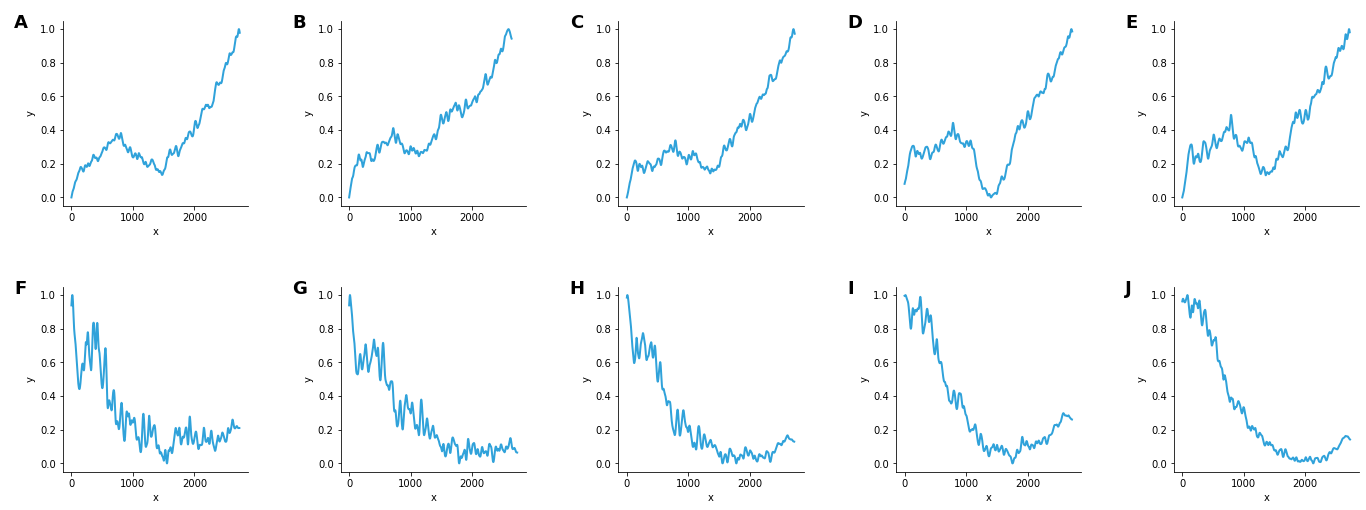

In [787]:
hv.Layout(curves).cols(5)

<hr>

In [911]:
# Diameter of a well in a 48-well plate
well_diam_mm = 10.7  # mm

# Well diameter in pixels
well_diam_pix = radii.mean() * 2

# Distance between pixels in microns
interpixel_distance = well_diam_mm / well_diam_pix * 1e3

interpixel_distance

3.355971005338818

In [912]:
# Get length of line profile in mm
lp_length_pix = np.linalg.norm(lp_verts[0, 1] - lp_verts[0, 0])
lp_length_mm  = lp_length_pix * interpixel_distance / 1e3

# Calculate distance along line profile
lp_dist = np.linspace(0, lp_length_mm, line_profiles.shape[1])

In [913]:
lp_dist

array([0.00000000e+00, 3.35515249e-03, 6.71030497e-03, ...,
       9.14614568e+00, 9.14950083e+00, 9.15285598e+00])

In [914]:
colnames = [
    (ch, hrs) 
    for ch, hrs in zip(
        np.repeat(np.array(["BFP (norm.)", "GFP (norm.)"]), 5),
        np.tile(["64h", "88h", "112h", "136h", "160h"], 2),
    )
]

In [958]:
lp_dict = {
    (".", "Distance (mm)"): lp_dist,
}

for i, col in enumerate(colnames):
    lp_dict[col] = line_prof_norm[i][::-1]

In [959]:
lp_df = pd.DataFrame(lp_dict)
lp_df

. BFP (norm.)                                          \
     Distance (mm)         64h       88h      112h      136h      160h   
0         0.000000    0.988546  0.899195  0.974132  0.985106  0.975530   
1         0.003355    0.990698  0.900422  0.975562  0.986721  0.978142   
2         0.006710    0.992682  0.901692  0.977107  0.988321  0.980793   
3         0.010065    0.994473  0.903003  0.978751  0.989889  0.983441   
4         0.013421    0.996049  0.904353  0.980475  0.991405  0.986036   
...            ...         ...       ...       ...       ...       ...   
2724      9.139435    0.007879  0.009390  0.006484  0.086235  0.006017   
2725      9.142791    0.005928  0.007195  0.004968  0.084550  0.004585   
2726      9.146146    0.003961  0.004892  0.003387  0.082793  0.003111   
2727      9.149501    0.001984  0.002490  0.001732  0.080967  0.001585   
2728      9.152856    0.000000  0.000000  0.000000  0.079076  0.000000   

     GFP (norm.)                                          
             64h       88h      112h      136h      160h  
0       0.210237  0.064595  0.128858  0.260171  0.142059  
1       0.210238  0.064664  0.128981  0.260319  0.142288  
2       0.210230  0.064727  0.129106  0.260446  0.142548  
3       0.210217  0.064786  0.129230  0.260559  0.142839  
4       0.210195  0.064846  0.129351  0.260660  0.143158  
...          ...       ...       ...       ...       ...  
2724    0.975676  0.981990  0.988900  0.995528  0.970537  
2725    0.970363  0.976656  0.985720  0.995455  0.968732  
2726    0.964565  0.970799  0.982169  0.995456  0.966776  
2727    0.958286  0.964504  0.978271  0.995514  0.964679  
2728    0.951533  0.957859  0.974053  0.995604  0.962455  

[2729 rows x 11 columns]

In [960]:
if save_data:
    lp_fname = "partial_activation_wave_line_profiles.csv"
    lp_path = os.path.join(os.path.realpath(data_dir), lp_fname)
    lp_df.to_csv(lp_path)

<hr>

# Regarding the speck

In [147]:
speck = np.s_[450:700, 1800:2100]

In [66]:
speck_im = ims_filt_uint8[4, ::-1][speck]

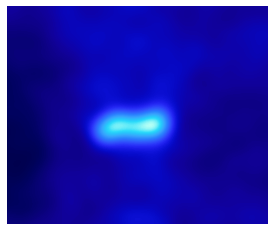

In [66]:
plt.imshow(speck_im, cmap=cc.cm["kbc"]);
plt.axis("off");

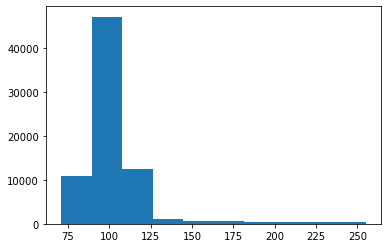

In [67]:
plt.hist(speck_im.ravel());

In [74]:
speck_thresh = 200
speck_mask = speck_im > speck_thresh

speck_masked = speck_im.copy()
speck_masked[speck_mask] = 0

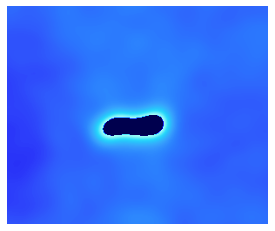

In [75]:
plt.imshow(speck_masked, cmap=cc.cm["kbc"]);
plt.axis("off");

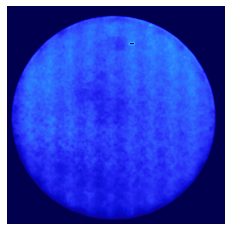

In [85]:
ims_masked = ims_filt_uint8.copy()

ims_mask = ims_masked > speck_thresh
ims_masked[ims_mask] = 0

plt.imshow(ims_masked[4][::-1], cmap=cc.cm["kbc"]);
plt.axis("off");

<hr>